In [1]:
import torch 

## Create and run a local RAG pipeline from scratch

The goal is to take information and pass it to an LLM. 

* Retrival - Find relevant information given to a query. 
* Augmented - We want to take the relevant information and augment our input(prompt) to an LLM
* Generation - Take the first two steps and pass them to an LLM 



### Why RAG?

1. Prevent hallucination 
2. Work with custom Data



1. Open a PDF
2. Format the text of the PDF TExtbook ready
3. Embed all of the chunks of text in the textbook
4. Build a Retrieval system that uses vector serach
5. Create a prompt
6. Generate an answer

### 1. Document / Text procesing and embedding creation 


In [2]:
import os 
import requests

pdf_path = "human-nutrition-text.pdf"

if not os.path.exists(pdf_path):
    print(f"[INFO] File doesn't exist, downloading...")

    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    filename = pdf_path

    response = requests.get(url)

    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.content)
        print("[INFO] the file has been download and saved")
    else:
        print(f"[INFO] failed to download the file. Status Code: {response.status_code}")
else:
    print(f"File {pdf_path} exists")

File human-nutrition-text.pdf exists


In [3]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text:str) -> str:
    cleaned_text = text.replace("\n" , " "). strip()

    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text= text_formatter(text=text)
        pages_and_texts.append({"Page_number": page_number - 41, "page_char_count": len(text), 
                                "page_word_count": len(text.split(" ")),
                                 "page_sentence_count_raw": len(text.split(". ")),
                                  "page_token_count": len(text) /4,
                                   "text": text })
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'Page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'Page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [4]:
import pandas as pd 
df = pd.DataFrame(pages_and_texts)
df.head()

,Page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [5]:
from spacy.lang.en import English

nlp = English()

#Add a sentencizer

nlp.add_pipe("sentencizer")




In [6]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item['text']).sents)

    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [7]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,Page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


## Chunking the sentences together
THe concept of splitting larger pieces of text into smaller ones is often referred to as text splitting or chunking. 

There is no 100% correct way to do this. 

In [8]:
num_sentence_chunk_size = 10

def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

In [9]:
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"], slice_size=num_sentence_chunk_size)

    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [10]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,Page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00,3.00


In [11]:
import re

pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["Page_number"]

        joined_sentence_chunk = "".join(sentence_chunk).replace(" ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])',r'. \1', joined_sentence_chunk)

        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) /4 

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [12]:
df = pd.DataFrame(pages_and_chunks)

In [13]:
min_token_length = 30

for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count : {row[1]["chunk_token_count"]}| Text: {row[1]["sentence_chunk"]}')

Chunk token count : 15.5| Text: Folate is also found in legumes, liver, and  Pregnancy  |  787
Chunk token count : 13.75| Text: PART VIII  CHAPTER 8. ENERGY  Chapter 8. Energy  |  451
Chunk token count : 17.25| Text: Table 4.6 Sweeteners  Carbohydrates and Personal Diet Choices  |  281
Chunk token count : 3.75| Text: 814  |  Infancy
Chunk token count : 9.5| Text: 1088  |  Nutrition, Health and Disease


In [14]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"]> min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020  Edition  UNIVERSITY OF HAWAI‘I AT MĀNOA  FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM  ALAN TITCHENAL, SKYLAR HARA,  NOEMI ARCEO CAACBAY, WILLIAM  MEINKE-LAU, YA-YUN YANG, MARIE  KAINOA FIALKOWSKI REVILLA,  JENNIFER DRAPER, GEMADY  LANGFELDER, CHERYL GIBBY, CHYNA  NICOLE CHUN, AND ALLISON  CALABRESE',
  'chunk_char_count': 320,
  'chunk_word_count': 54,
  'chunk_token_count': 80.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program is licensed under a Creative Commons Attribution 4.0  International License, except where otherwise noted.',
  'chunk_char_count': 212,
  'chunk_word_count': 32,
  'chunk_token_count': 53.0},
 {'page_number': -37,
  'sentence_chunk': 'Contents  Preface  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  xxv  About the Contributors  University of Ha

### Embedding the chunks

In [15]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cuda")

sentences = ["The Sentence Transformer Library provides an easy way to create embeddings", "Sentences can be embeedded on by one or in a lost", "I like horses!"] 


embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")

c:\ProgramData\anaconda3\envs\pytgpu\Lib\site-packages\transformers\utils\hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
C:\Users\Monish K.S\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\Monish K.S\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: The Sentence Transformer Library provides an easy way to create embeddings
Embedding: [-3.17512564e-02  3.37267891e-02 -2.52437778e-02  5.22287637e-02
 -2.35248990e-02 -6.19114190e-03  1.35026118e-02 -6.25500977e-02
  7.50828627e-03 -2.29684431e-02  2.98147015e-02  4.57555018e-02
 -3.26700285e-02  1.39847510e-02  4.18013781e-02 -5.92969283e-02
  4.26309742e-02  5.04662190e-03 -2.44552735e-02  3.98593675e-03
  3.55897695e-02  2.78742835e-02  1.84098538e-02  3.67699824e-02
 -2.29960773e-02 -3.01796980e-02  5.99522900e-04 -3.64504121e-02
  5.69104627e-02 -7.49940984e-03 -3.70004140e-02 -3.04358406e-03
  4.64355052e-02  2.36151065e-03  9.06849777e-07  7.00037042e-03
 -3.92289422e-02 -5.95696177e-03  1.38653032e-02  1.87108153e-03
  5.34202456e-02 -6.18613772e-02  2.19613612e-02  4.86051142e-02
 -4.25697677e-02 -1.69858914e-02  5.04178368e-02  1.54734040e-02
  8.12859386e-02  5.07106148e-02 -2.27497090e-02 -4.35721092e-02
 -2.18388671e-03 -2.14091521e-02 -2.01758463e-02  3.0683273

In [16]:
%%time

embedding_model.to('cuda')

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]


for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1685 [00:00<?, ?it/s]

CPU times: total: 5.58 s
Wall time: 50.7 s


In [17]:
%%time 
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size =32, convert_to_tensor=True )

CPU times: total: 3.06 s
Wall time: 16 s


In [18]:
## Save Embeddings 
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunk_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [19]:
text_chunks_and_embeddings_df_load = pd.read_csv("text_chunk_and_embeddings_df.csv")


### Similarity Search

Embeddings can be used for almost anything



In [20]:
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else 'cpu'

text_chunks_and_embeddings_df = pd.read_csv("text_chunk_and_embeddings_df.csv")

text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x:np.fromstring(x.strip("[]") , sep=" "))

embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df["embedding"].tolist(), axis=0), dtype=torch.float32).to(device)

pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

text_chunks_and_embeddings_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF ...,320,54,80.00,"[0.0674242526, 0.0902280957, -0.00509548979, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,212,32,53.00,"[0.0552156232, 0.0592139475, -0.0166167412, -0..."
2,-37,Contents Preface University of Hawai‘i at Mā...,797,147,199.25,"[0.0279801842, 0.0339813866, -0.0206426587, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘...,976,179,244.00,"[0.0682566836, 0.0381274894, -0.00846855342, -..."
4,-35,The Cardiovascular System University of Hawai...,1037,191,259.25,"[0.0330264457, -0.00849767867, 0.00957159325, ..."
...,...,...,...,...,...,...
1680,1164,Flashcard Images Note: Most images in the fla...,1329,211,332.25,"[0.0185622629, -0.0164277516, -0.0127045782, -..."
1681,1164,Hazard Analysis Critical Control Points reused...,383,60,95.75,"[0.0334720686, -0.0570440665, 0.0151489256, -0..."
1682,1165,ShareAlike 11. Organs reused “Pancreas Organ ...,1312,202,328.00,"[0.0770515203, 0.00978558417, -0.0121817337, 0..."
1683,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,420,73,105.00,"[0.103045173, -0.0164701883, 0.0082684271, 0.0..."


In [21]:
embeddings.shape

torch.Size([1685, 768])

In [22]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)



C:\Users\Monish K.S\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [23]:
# Define The query

query = "macronutrients functions"
print(f'Query : {query}')

#Embed query
query_embedding = embedding_model.encode(query,convert_to_tensor=True).to("cuda")

#Get similarity scores
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a = query_embedding, b = embeddings)[0]
end_time= timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds")

#Get the top-k results 

top_results_dot_product = torch.topk(dot_scores, k = 5)
top_results_dot_product

Query : macronutrients functions
[INFO] Time taken to get scores on 1685 embeddings: 0.00232 seconds


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))

In [26]:
large_embeddings = torch.randn(100*embeddings.shape[0],768).to(device)
print(f'Embeddings shape: {large_embeddings.shape}')

# Perform dot product
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=large_embeddings)[0]
end_time = timer()

print(
    f"[INFO] Time taken to get scores on {len(large_embeddings)} embeddings: {end_time - start_time:.5f} seconds"
)

Embeddings shape: torch.Size([1685000, 768])
[INFO] Time taken to get scores on 1685000 embeddings: 0.05636 seconds


We can see that it's very fast even with Exhaustive search

But for 10M+ embeddings, you have to create an index 

In [35]:
import textwrap


def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [36]:
pages_and_chunks[0]

{'page_number': -39,
 'sentence_chunk': 'Human Nutrition: 2020  Edition  UNIVERSITY OF HAWAI‘I AT MĀNOA  FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM  ALAN TITCHENAL, SKYLAR HARA,  NOEMI ARCEO CAACBAY, WILLIAM  MEINKE-LAU, YA-YUN YANG, MARIE  KAINOA FIALKOWSKI REVILLA,  JENNIFER DRAPER, GEMADY  LANGFELDER, CHERYL GIBBY, CHYNA  NICOLE CHUN, AND ALLISON  CALABRESE',
 'chunk_char_count': 320,
 'chunk_word_count': 54,
 'chunk_token_count': 80.0,
 'embedding': array([ 6.74242526e-02,  9.02280957e-02, -5.09548979e-03, -3.17545459e-02,
         7.39082247e-02,  3.51976380e-02, -1.97987147e-02,  4.67692576e-02,
         5.35727106e-02,  5.01229335e-03,  3.33929136e-02, -1.62219477e-03,
         1.76080689e-02,  3.62653434e-02, -3.16729798e-04, -1.07118040e-02,
         1.54257901e-02,  2.62175929e-02,  2.77654524e-03,  3.64942774e-02,
        -4.44109552e-02,  1.89361796e-02,  4.90117855e-02,  1.64020061e-02,
        -4.85782549e-02,  3.18288105e-03,  2.72992682e-02, -2.04759021e-03,
        -1.2

In [37]:
query = "macronutrient functions"
print(f'Query: {query} \n')
print('Results:')
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page Number: {pages_and_chunks[idx]['page_number']}")
    print('\n')

Query: macronutrient functions 

Results:
Score: 0.6926
Text:
Macronutrients  Nutrients  that  are  needed  in  large  amounts  are  called
macronutrients. There are three classes of macronutrients:  carbohydrates,
lipids, and proteins. These can be metabolically  processed into cellular
energy. The energy from macronutrients  comes from their chemical bonds. This
chemical energy is  converted into cellular energy that is then utilized to
perform work,  allowing our bodies to conduct their basic functions. A unit of
measurement of food energy is the calorie. On nutrition food labels  the amount
given for “calories” is actually equivalent to each calorie  multiplied by one
thousand. A kilocalorie (one thousand calories,  denoted with a small “c”) is
synonymous with the “Calorie” (with a  capital “C”) on nutrition food labels.
Water is also a macronutrient in  the sense that you require a large amount of
it, but unlike the other  macronutrients, it does not yield calories.
Carbohydrates 

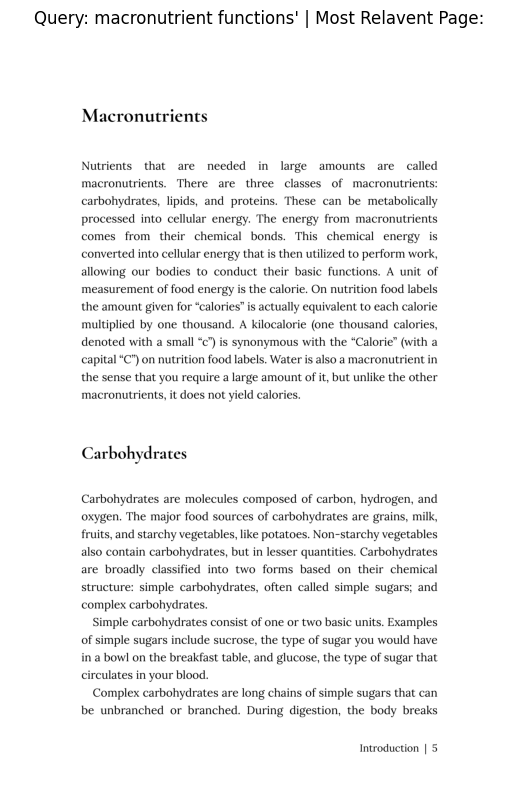

In [42]:
import fitz

pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41)

img  = page.get_pixmap(dpi=300)

doc.close()

img_array = np.frombuffer(img.samples_mv, dtype = np.uint8).reshape((img.h, img.w, img.n))


import matplotlib.pyplot as plt
plt.figure(figsize = (13,10))
plt.imshow(img_array)
plt.title(f"Query: {query}' | Most Relavent Page:")
plt.axis('off')
plt.show()
